In [24]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier,plot_importance
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

### Data Exploration

In [25]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
print(df)

       age           job   marital  education default  balance housing loan  \
0       58    management   married   tertiary      no     2143     yes   no   
1       44    technician    single  secondary      no       29     yes   no   
2       33  entrepreneur   married  secondary      no        2     yes  yes   
3       47   blue-collar   married    unknown      no     1506     yes   no   
4       33       unknown    single    unknown      no        1      no   no   
...    ...           ...       ...        ...     ...      ...     ...  ...   
39995   53    technician   married   tertiary      no      395      no   no   
39996   30    management    single   tertiary      no     3340      no   no   
39997   54         admin  divorced  secondary      no      200      no   no   
39998   34    management   married   tertiary      no     1047      no   no   
39999   38    technician   married  secondary      no     1442     yes   no   

        contact  day month  duration  campaign    y

In [26]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [27]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no
39999,38,technician,married,secondary,no,1442,yes,no,cellular,3,jun,113,1,no


In [28]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


### Data cleaning

1- Check for missing values

In [30]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

No missing values are present

2- Checking outliers

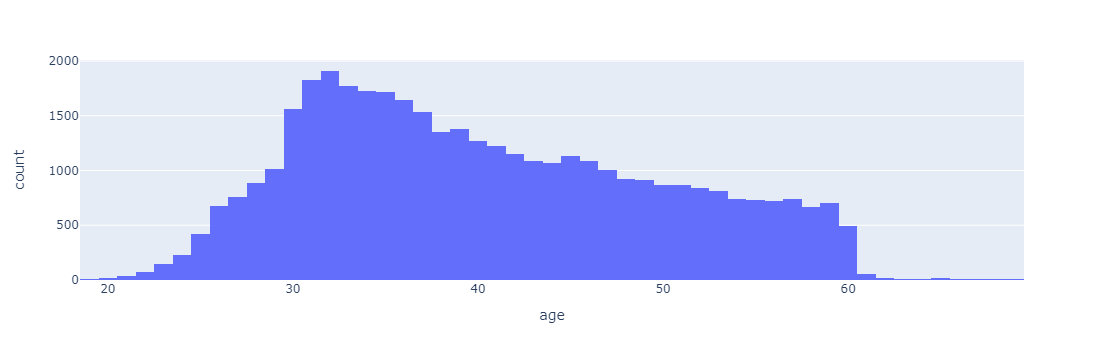

In [31]:
fig = px.histogram(df[df.age<70], x="age")
fig

We can see that the majority of people have age between 30 and 40. After 60 only few samples are present

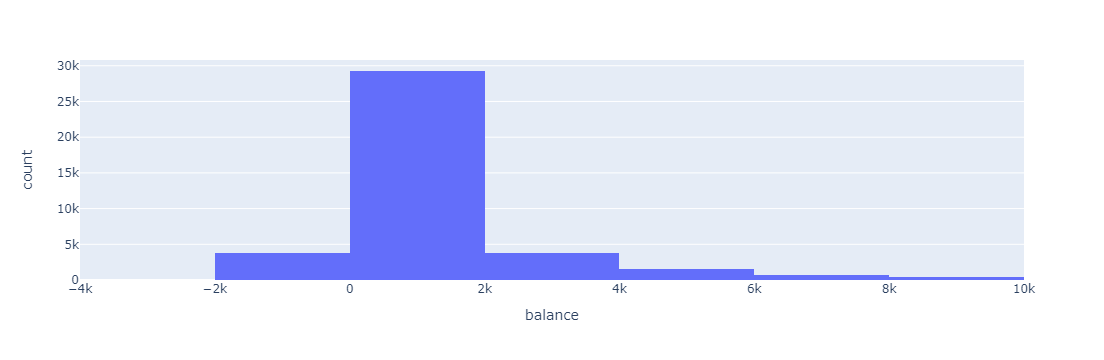

In [32]:
fig = px.histogram(df[(-3000<= df['balance']) & (df['balance']<=10000)], x="balance",nbins=10)
fig

The majority of the people have the balance in the range between 0 and 2k with very few samples after 6k.

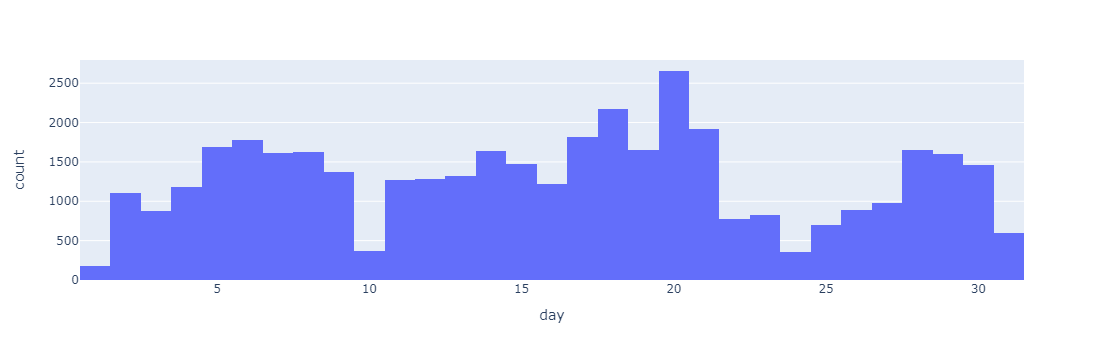

In [33]:
fig = px.histogram(df['day'], x="day")
fig

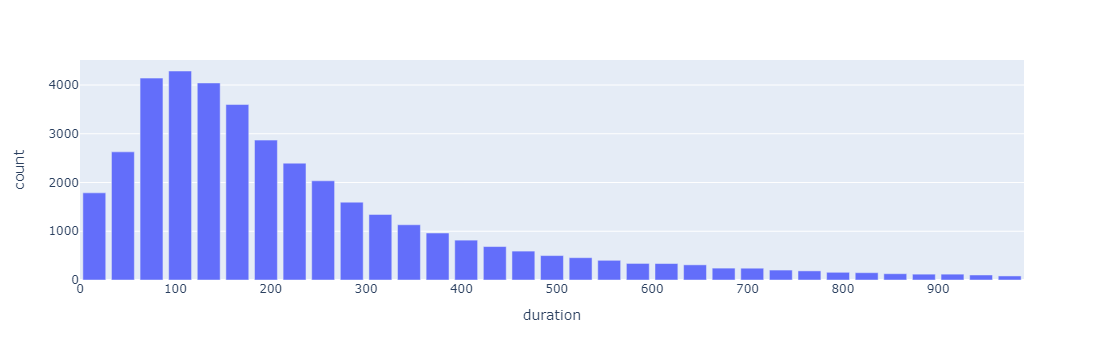

In [34]:
counts, bins = np.histogram(df.duration, bins=range(0, 1000, 30))
bins = 0.5 * (bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, labels={'x':'duration', 'y':'count'})
fig

The duration of the last contact seems to be in the range of 500 seconds for most people, the number of people decrease constantly after that

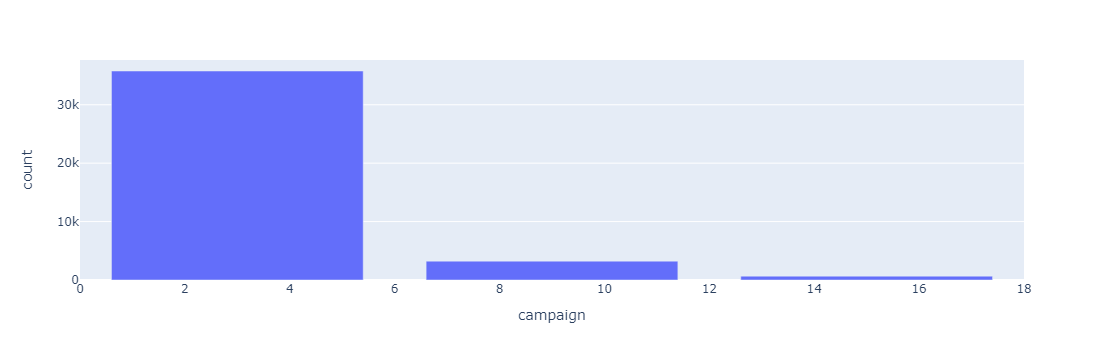

In [35]:
counts, bins = np.histogram(df.campaign, bins=range(0, 21, 6))
bins = 0.5 * (bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, labels={'x':'campaign', 'y':'count'})
fig

The number of contacts performed during this campaign seems to be approximately between one and 1 and 3 for most client rarely exceeding 13.

### Visualize data and features engineering

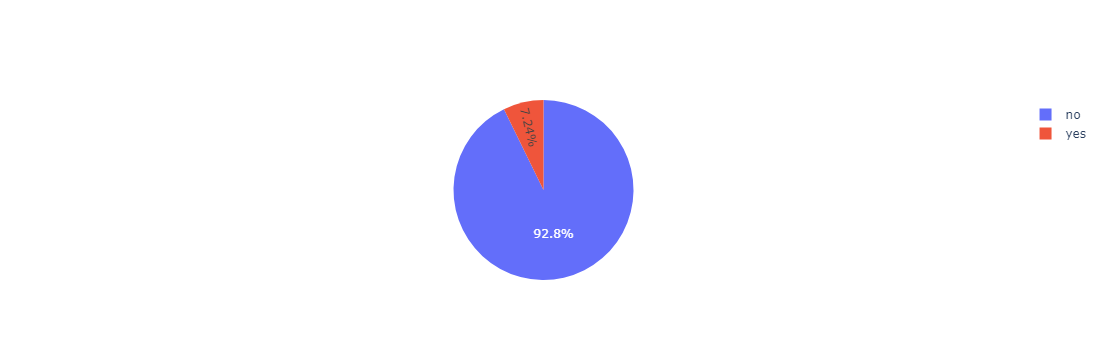

In [36]:
subscriber_counts = df['y'].value_counts()
fig = go.Figure(data=[go.Pie(labels=subscriber_counts.keys().tolist(), values=subscriber_counts)])
fig

In [37]:
df['y']=pd.factorize(df['y'])[0]

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 4.3+ MB


In [39]:
df_sub = df[df.y==1]
df_sub.shape

(2896, 14)

In [40]:
df_not_sub = df[df.y==0]
df_not_sub.shape

(37104, 14)

The data are unbalanced with only 2896 subscriber aganist 37104 non subscriber. We need to remember this in the classification task.

#### Age

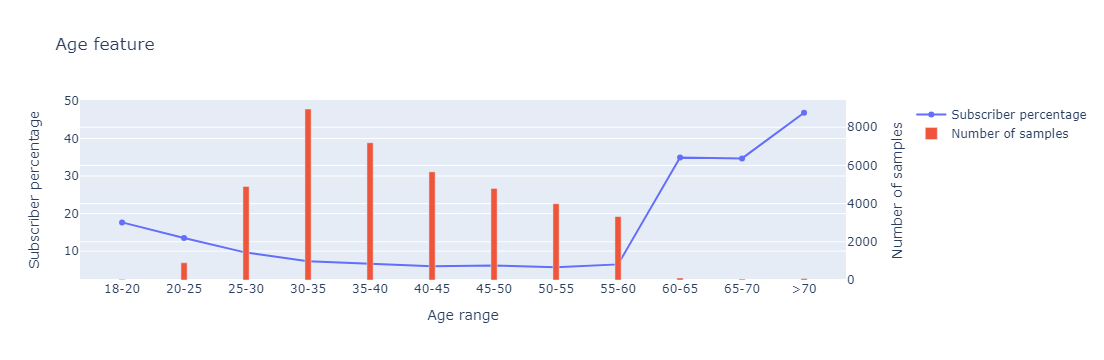

In [41]:
label = ['18-20','20-25', '25-30', '30-35','35-40','40-45','45-50','50-55','55-60','60-65','65-70','>70']
num_samp_age = [(df[(18 <= df['age']) & (df['age'] <= 20)]).shape[0],(df[(20 < df['age']) & (df['age'] <= 25)]).shape[0],(df[(25 < df['age']) & (df['age'] <= 30)]).shape[0],(df[(30 < df['age']) & (df['age'] <= 35)]).shape[0],(df[(35 < df['age']) & (df['age'] <= 40)]).shape[0],(df[(40 < df['age']) & (df['age'] <= 45)]).shape[0],(df[(45 < df['age']) & (df['age'] <= 50)]).shape[0],(df[(50 < df['age']) & (df['age'] <= 55)]).shape[0],(df[(55 < df['age']) & (df['age'] <= 60)]).shape[0],(df[(60 < df['age']) & (df['age'] <= 65)]).shape[0],(df[(65 < df['age']) & (df['age'] <= 70)]).shape[0],(df[(df['age'] > 70)]).shape[0]]
perc_age = [round((df[(18 <= df['age']) & (df['age'] <= 20)& (df['y'] == 1)]).shape[0]/num_samp_age[0]*100,2),round((df[(20 < df['age']) & (df['age'] <= 25)& (df['y'] == 1)]).shape[0]/num_samp_age[1]*100,2),round((df[(25 < df['age']) & (df['age'] <= 30)& (df['y'] == 1)]).shape[0]/num_samp_age[2]*100,2),round((df[(30 < df['age']) & (df['age'] <= 35)& (df['y'] == 1)]).shape[0]/num_samp_age[3]*100,2),round((df[(35 < df['age']) & (df['age'] <= 40)& (df['y'] == 1)]).shape[0]/num_samp_age[4]*100,2),round((df[(40 < df['age']) & (df['age'] <= 45)& (df['y'] == 1)]).shape[0]/num_samp_age[5]*100,2),round((df[(45 < df['age']) & (df['age'] <= 50)& (df['y'] == 1)]).shape[0]/num_samp_age[6]*100,2),round((df[(50 < df['age']) & (df['age'] <= 55)& (df['y'] == 1)]).shape[0]/num_samp_age[7]*100,2),round((df[(55 < df['age']) & (df['age'] <= 60)& (df['y'] == 1)]).shape[0]/num_samp_age[8]*100,2),round((df[(60 < df['age']) & (df['age'] <= 65)& (df['y'] == 1)]).shape[0]/num_samp_age[9]*100,2),round((df[(65 < df['age']) & (df['age'] <= 70)& (df['y'] == 1)]).shape[0]/num_samp_age[10]*100,2),round((df[(df['age'] > 70)& (df['y'] == 1)]).shape[0]/num_samp_age[11]*100,2)]
# Create Plot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_age, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_age, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Age feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Age range")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

The subscriber percentage increase after 60 years old

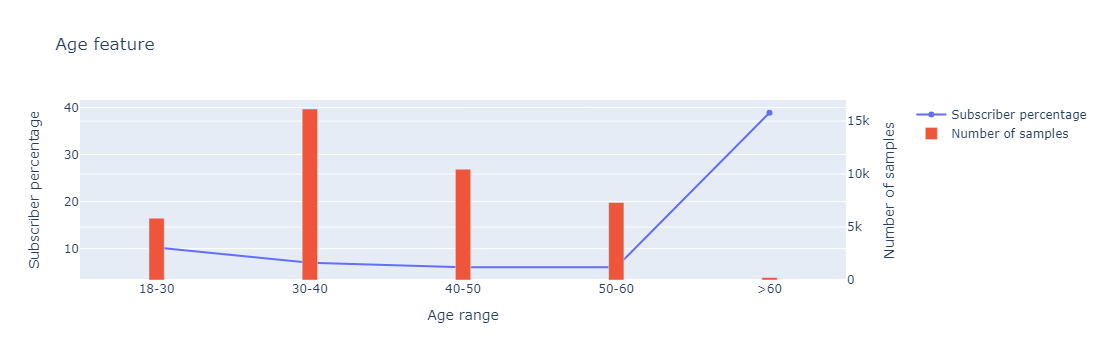

In [42]:
label = ['18-30','30-40', '40-50', '50-60','>60']
num_samp_age = [(df[(18 <= df['age']) & (df['age'] <= 30)]).shape[0],(df[(30 < df['age']) & (df['age'] <= 40)]).shape[0],(df[(40 < df['age']) & (df['age'] <= 50)]).shape[0],(df[(50 < df['age']) & (df['age'] <= 60)]).shape[0],(df[(df['age'] > 60)]).shape[0]]
perc_age = [round((df[(18 <= df['age']) & (df['age'] <= 30)& (df['y'] == 1)]).shape[0]/num_samp_age[0]*100,2),round((df[(30 < df['age']) & (df['age'] <= 40)& (df['y'] == 1)]).shape[0]/num_samp_age[1]*100,2),round((df[(40 < df['age']) & (df['age'] <= 50)& (df['y'] == 1)]).shape[0]/num_samp_age[2]*100,2),round((df[(50 < df['age']) & (df['age'] <= 60)& (df['y'] == 1)]).shape[0]/num_samp_age[3]*100,2),round((df[(df['age'] > 60)& (df['y'] == 1)]).shape[0]/num_samp_age[4]*100,2)]
# Create Plot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_age, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_age, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Age feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Age range")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

In [43]:
def func(x):
    if x >= 18 and x<=30:
        return '18-30'
    elif x > 30 and x<=40:
        return '30-40'
    elif x > 40 and x<=50:
        return '40-50'
    elif x > 50 and x<=60:
        return '50-60'
    else:
        return 'over60'
df['age'] = df['age'].apply(func)

### Job

In [44]:
print(df['job'].unique()) 

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']


In [45]:
print(df['job'].value_counts()) 

job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: count, dtype: int64


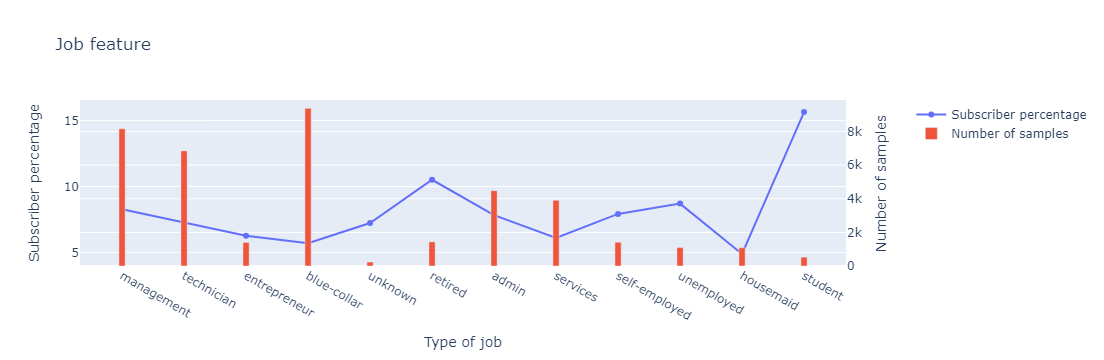

In [46]:
label = ['management','technician','entrepreneur','blue-collar','unknown','retired','admin','services','self-employed','unemployed','housemaid','student']
num_samp_job = []
perc_job = []
for l in label:
    num_samp_job.append(df[df.job==l].shape[0])
for i,l in enumerate(label):
    perc_job.append(round((df[(df.job==l) & (df['y'] == 1)]).shape[0]/num_samp_job[i]*100,2))
# Create Plot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_job, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_job, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Job feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Type of job")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

Student and retired seems to have the larger number of subscriber. Given the number of categories and samples it would be better to merge categories together. The categories unemployed, housemaid, student, unknown, retired and self-employed will be grouped together in the category 'Not full-time job'. The categories admin, technician, services will be grouped together in the category 'Office job' and the categories entrepreneur, management, blue-collar will be grouped together in the category 'High profile job'.

In [47]:
d = {'technician':'office job','admin':'office job','services':'office job','unemployed':'not full-time job','housemaid':'not full-time job','student':'not full-time job','unknown':'not full-time job','retired':'not full-time job','self-employed':'not full-time job','entrepreneur':'high profile job','management':'high profile job','blue-collar':'high profile job'}
df['job'] = df['job'].replace(d)
df_sub['job'] = df_sub['job'].replace(d)
df_not_sub['job'] = df_not_sub['job'].replace(d)

C:\Users\PicardiC\AppData\Local\Temp\ipykernel_17240\2856525914.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PicardiC\AppData\Local\Temp\ipykernel_17240\2856525914.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
print(df['job'].unique()) 
print(df_sub['job'].unique())
print(df_not_sub['job'].unique())


['high profile job' 'office job' 'not full-time job']
['office job' 'high profile job' 'not full-time job']
['high profile job' 'office job' 'not full-time job']


In [49]:
print(df['job'].value_counts()) 

job
high profile job     18954
office job           15245
not full-time job     5801
Name: count, dtype: int64


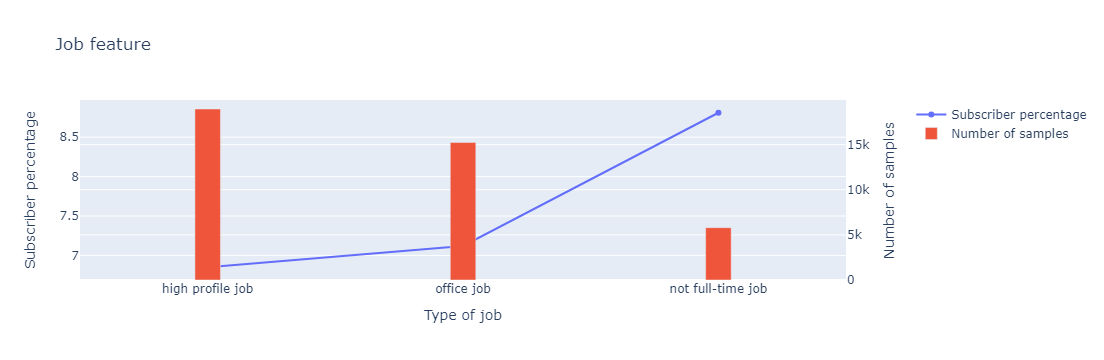

In [50]:
label = ['high profile job','office job','not full-time job' ]
num_samp_job = []
perc_job = []
for l in label:
    num_samp_job.append(df[df.job==l].shape[0])
for i,l in enumerate(label):
    perc_job.append(round((df[(df.job==l) & (df['y'] == 1)]).shape[0]/num_samp_job[i]*100,2))
# Create Plot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_job, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_job, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Job feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Type of job")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

Unexepectly the percentage of subscribers decrease with position grow, but this can be due to the limited number of sample in not a full-time job category.Also the result is determined by the two categories student and retired which have a larger number of subscriber. 

#### Marital

In [51]:
print(df['marital'].unique()) 

['married' 'single' 'divorced']


In [52]:
print(df['marital'].value_counts()) 

marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64


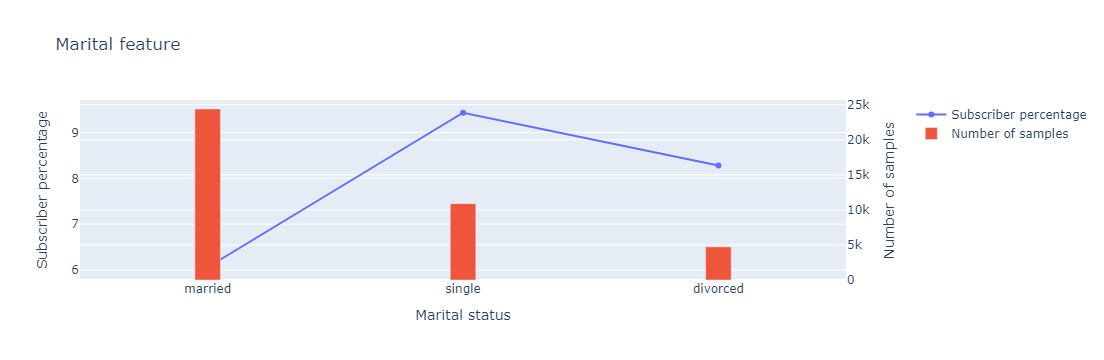

In [53]:
label = ['married','single', 'divorced']
num_samp_mar = []
perc_mar = []
for l in label:
    num_samp_mar.append(df[df.marital==l].shape[0])
for i,l in enumerate(label):
    perc_mar.append(round((df[(df.marital==l) & (df['y'] == 1)]).shape[0]/num_samp_mar[i]*100,2))
# Create Plot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_mar, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_mar, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Marital feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Marital status")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

The greatest subscriber percentage is in the single people. The reason of this could be related to less expenses or just related to sample size.

#### Education

In [54]:
print(df['education'].unique()) 

['tertiary' 'secondary' 'unknown' 'primary']


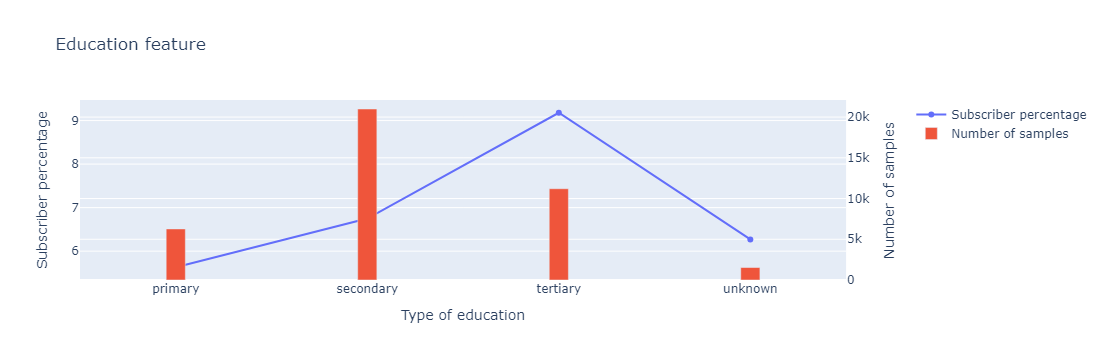

In [55]:
label = ['primary', 'secondary', 'tertiary', 'unknown']
num_samp_ed = []
perc_ed = []
for l in label:
    num_samp_ed.append(df[df.education==l].shape[0])
for i,l in enumerate(label):
    perc_ed.append(round((df[(df.education==l) & (df['y'] == 1)]).shape[0]/num_samp_ed[i]*100,2))
# Create Plot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_ed, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_ed, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Education feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Type of education")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

The percentage of subscriber increases with the level of education. This feature seems to affect the target.

#### Default

In [56]:
print(df['default'].unique()) 

['no' 'yes']


In [57]:
print(df['default'].value_counts()) 

default
no     39191
yes      809
Name: count, dtype: int64


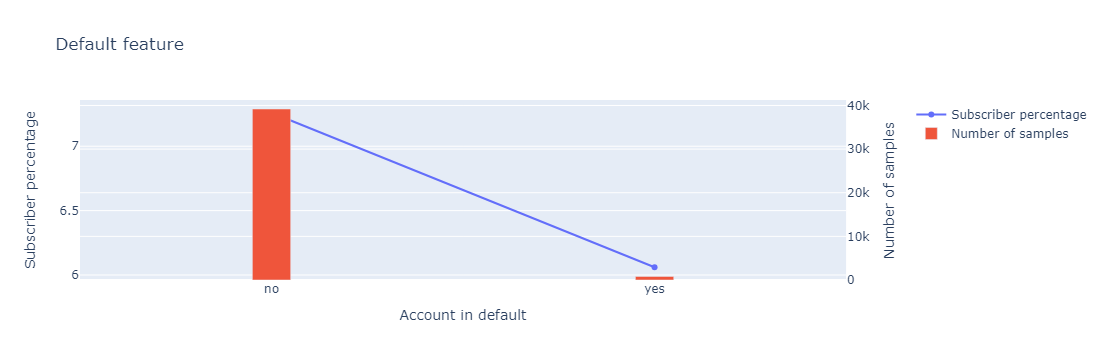

In [58]:
label = ['no', 'yes']
num_samp_def = []
perc_def = []
for l in label:
    num_samp_def.append((df[df.default==l]).shape[0])
for i,l in enumerate(label):
    perc_def.append(round((df[(df.default==l) & (df['y'] == 1)]).shape[0]/num_samp_def[i]*100,2))
# Create Plot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_def, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_def, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Default feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Account in default")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

In [59]:
df['default']=pd.factorize(df['default'])[0]

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  object
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  int64 
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 4.3+ MB


In [61]:
print(df['default'].value_counts())

default
0    39191
1      809
Name: count, dtype: int64


As expected the majority of subscriber doesn't have a default on the account.

#### Balance

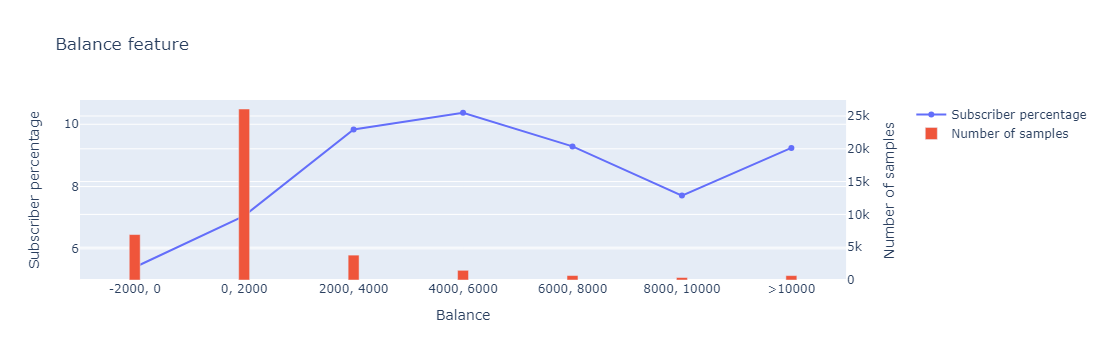

In [62]:
label = ['-2000, 0','0, 2000','2000, 4000','4000, 6000','6000, 8000','8000, 10000', '>10000']
num_samp_bal = [(df[(-2000 <= df['balance']) & (df['balance'] <= 0)]).shape[0],(df[(0 < df['balance']) & (df['balance'] <= 2000)]).shape[0],(df[(2000 < df['balance']) & (df['balance'] <= 4000)]).shape[0],(df[(4000 < df['balance']) & (df['balance'] <= 6000)]).shape[0],(df[(6000 < df['balance']) & (df['balance'] <= 8000)]).shape[0],(df[(8000 < df['balance']) & (df['balance'] <= 10000)]).shape[0],(df[(df['balance'] > 10000)].shape[0])]
perc_bal = [round((df_sub[(-2000 <= df_sub['balance']) & (df_sub['balance'] <= 0)]).shape[0]/num_samp_bal[0]*100,2),round((df_sub[(0 < df_sub['balance']) & (df_sub['balance'] <= 2000)]).shape[0]/num_samp_bal[1]*100,2),round((df_sub[(2000 < df_sub['balance']) & (df_sub['balance'] <= 4000)]).shape[0]/num_samp_bal[2]*100,2),round((df_sub[(4000 < df_sub['balance']) & (df_sub['balance'] <= 6000)]).shape[0]/num_samp_bal[3]*100,2),round((df_sub[(6000 < df_sub['balance']) & (df_sub['balance'] <= 8000)]).shape[0]/num_samp_bal[4]*100,2),round((df_sub[(8000 < df_sub['balance']) & (df_sub['balance'] <= 10000)]).shape[0]/num_samp_bal[5]*100,2),round((df_sub[(df_sub['balance'] > 10000)]).shape[0]/num_samp_bal[6]*100,2)]

# Create Plot

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_bal, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_bal, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Balance feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Balance")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

The percentage of subscriber increases in the range 2000-4000 and 4000-6000, then decreases again for the range 6000-8000 and 8000-10000 finally increasing in balance>10000. So it seems that subscriber are more in people with medium and high-balance. Considering after 6k we have only few samples let's do a different grouping. 

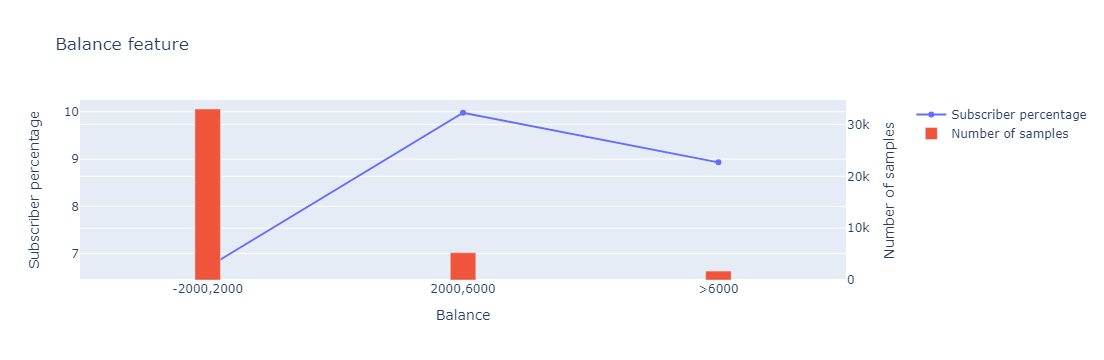

In [63]:
label = ['-2000,2000', '2000,6000','>6000']
num_samp_bal = [(df[(-2000 <= df['balance']) & (df['balance'] <= 2000)]).shape[0],(df[(2000 < df['balance']) & (df['balance'] <= 6000)]).shape[0],(df[(df['balance'] > 6000)]).shape[0]]
perc_bal = [round((df_sub[(-2000 <= df_sub['balance']) & (df_sub['balance'] <= 2000)]).shape[0]/num_samp_bal[0]*100,2),round((df_sub[(2000 < df_sub['balance']) & (df_sub['balance'] <= 6000)]).shape[0]/num_samp_bal[1]*100,2),round((df_sub[(df_sub['balance'] > 6000)]).shape[0]/num_samp_bal[2]*100,2)]

# Create Plot

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_bal, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_bal, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Balance feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Balance")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

In [64]:
def func(x):
    if x >= -2000 and x<=2000:
        return 'low-balance'
    elif x > 2000 and x<=6000:
        return 'medium-balance'
    else:
        return 'high-balance'
df['balance'] = df['balance'].apply(func)

#### Housing

In [65]:
print(df['housing'].unique())

['yes' 'no']


In [66]:
print(df['housing'].value_counts())

housing
yes    24031
no     15969
Name: count, dtype: int64


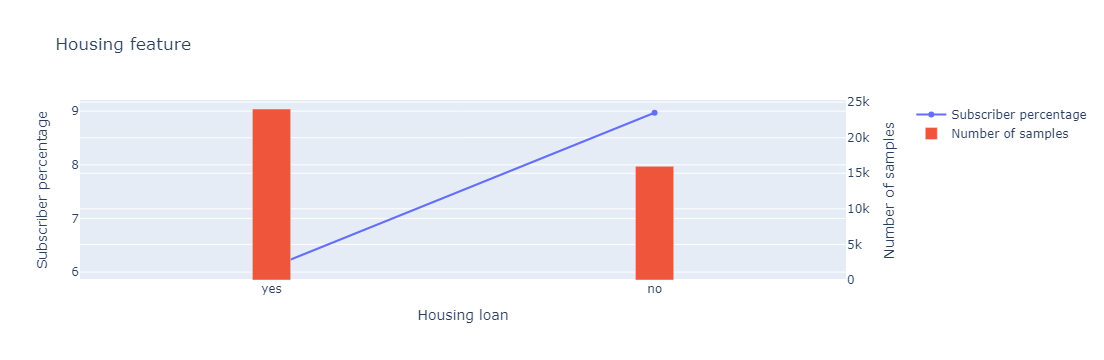

In [67]:
label = ['yes','no']
num_samp_hou = []
perc_hou = []
for l in label:
    num_samp_hou.append((df[df.housing==l]).shape[0])
for i,l in enumerate(label):
    perc_hou.append(round((df[(df.housing==l) & (df['y'] == 1)]).shape[0]/num_samp_hou[i]*100,2))
# Create Plot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_hou, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_hou, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Housing feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Housing loan")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

As expected the percentage of subscriber is greater in people without house loan

In [68]:
df['housing']=pd.factorize(df['housing'])[0]

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  object
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  int64 
 5   balance    40000 non-null  object
 6   housing    40000 non-null  int64 
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 4.3+ MB


In [70]:
print(df['housing'].value_counts())

housing
0    24031
1    15969
Name: count, dtype: int64


#### Loan

In [71]:
print(df['loan'].unique())

['no' 'yes']


In [72]:
print(df['loan'].value_counts())

loan
no     33070
yes     6930
Name: count, dtype: int64


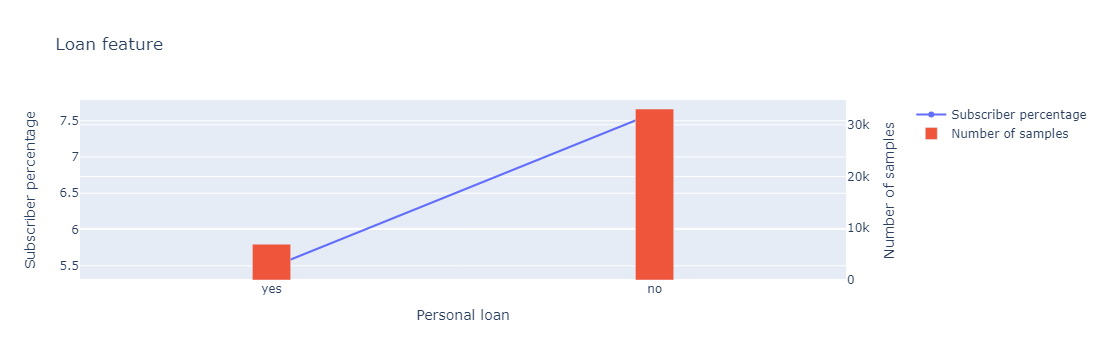

In [73]:
label = ['yes','no']
num_samp_loan = []
perc_loan = []
for l in label:
    num_samp_loan.append((df[df.loan==l]).shape[0])
for i,l in enumerate(label):
    perc_loan.append(round((df[(df.loan==l) & (df['y'] == 1)]).shape[0]/num_samp_loan[i]*100,2))
# Create Plot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_loan, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_loan, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text= "Loan feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Personal loan")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

As expected the percentage of subscriber is greater in people without a personal loan.

In [74]:
df['loan']=pd.factorize(df['loan'])[0]

In [75]:
print(df['loan'].value_counts())

loan
0    33070
1     6930
Name: count, dtype: int64


#### Contact

In [76]:
print(df['contact'].unique())

['unknown' 'cellular' 'telephone']


In [77]:
print(df['contact'].value_counts())

contact
cellular     24914
unknown      12765
telephone     2321
Name: count, dtype: int64


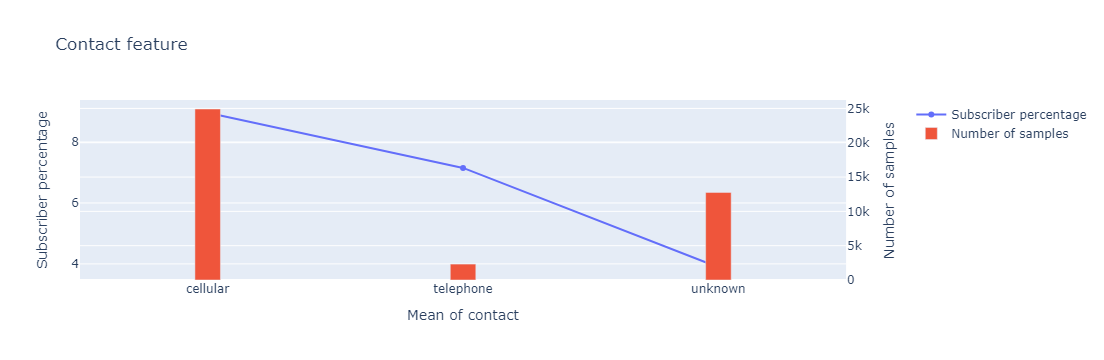

In [78]:
label = ['cellular', 'telephone', 'unknown']
num_samp_con = []
perc_con = []
for l in label:
    num_samp_con.append((df[df.contact==l]).shape[0])
for i,l in enumerate(label):
    perc_con.append(round((df[(df.contact==l) & (df['y'] == 1)]).shape[0]/num_samp_con[i]*100,2))
# Create Plot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_con, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_con, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Contact feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Mean of contact")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

People contacted with cellular seem to have the greatest number of subscriber, but it could just be related to the number of samples. Let's drop this feature.

#### Day

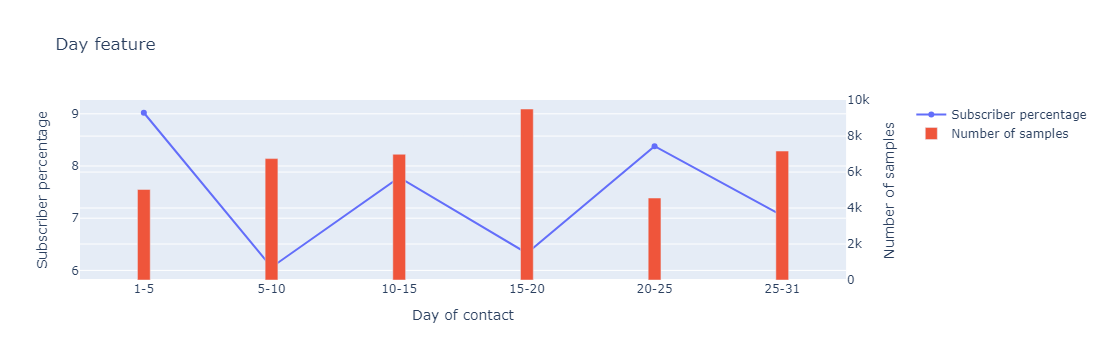

In [79]:
label = ['1-5','5-10','10-15','15-20','20-25','25-31']
num_samp_day = [(df[(1 <= df['day']) & (df['day'] <= 5)]).shape[0],(df[(5 < df['day']) & (df['day'] <= 10)]).shape[0],(df[(10 < df['day']) & (df['day'] <= 15)]).shape[0],(df[(15 < df['day']) & (df['day'] <= 20)]).shape[0],(df[(20 < df['day']) & (df['day'] <= 25)]).shape[0],(df[(df['day'] > 25)].shape[0])]
perc_day = [round((df_sub[(1 <= df_sub['day']) & (df_sub['day'] <= 5)]).shape[0]/num_samp_day[0]*100,2),round((df_sub[(5 < df_sub['day']) & (df_sub['day'] <= 10)]).shape[0]/num_samp_day[1]*100,2),round((df_sub[(10 < df_sub['day']) & (df_sub['day'] <= 15)]).shape[0]/num_samp_day[2]*100,2),round((df_sub[(15 < df_sub['day']) & (df_sub['day'] <= 20)]).shape[0]/num_samp_day[3]*100,2),round((df_sub[(20 < df_sub['day']) & (df_sub['day'] <= 25)]).shape[0]/num_samp_day[4]*100,2),round((df_sub[(df_sub['day'] > 25)]).shape[0]/num_samp_day[5]*100,2)]

# Create Plot

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_day, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_day, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Day feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Day of contact")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

The percentage of subscriber seems to increase around payday days

#### Month

In [80]:
df['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr'], dtype=object)

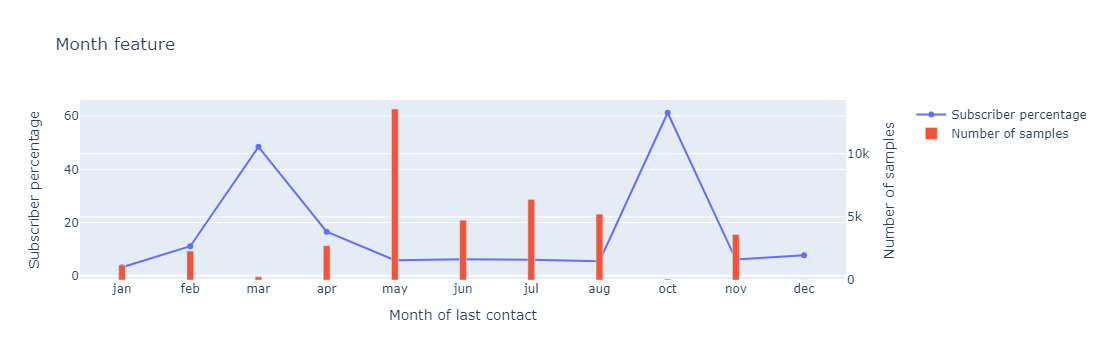

In [81]:
label = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec']
num_samp_mon = []
perc_mon = []
for l in label:
    num_samp_mon.append((df[df.month==l]).shape[0])
for i,l in enumerate(label):
    perc_mon.append(round((df[(df.month==l) & (df['y'] == 1)]).shape[0]/num_samp_mon[i]*100,2))
# Create Plot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_mon, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_mon, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Month feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Month of last contact")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

October and march have the gratest number of subscriber but this could be due just to the sample size, so this variable can be dropped.

#### Duration

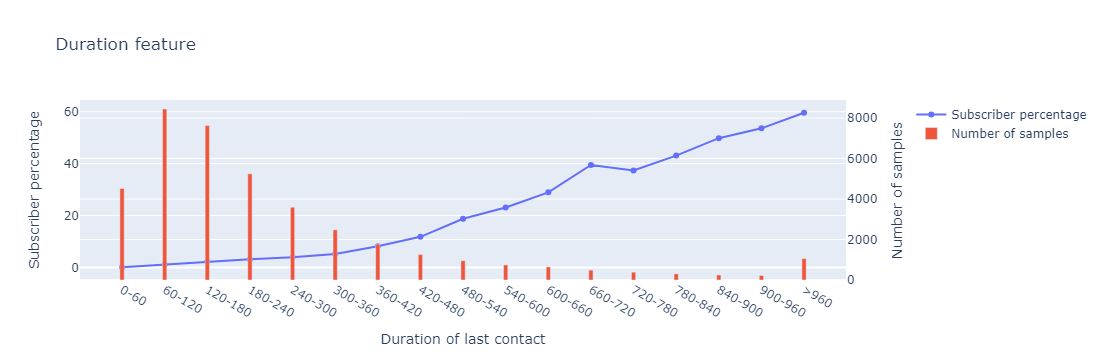

In [82]:
label = ['0-60','60-120','120-180','180-240','240-300','300-360','360-420','420-480','480-540','540-600','600-660','660-720','720-780','780-840','840-900','900-960','>960']
num_samp_dur = [(df[(0 <= df['duration']) & (df['duration'] <= 60)]).shape[0],(df[(60 < df['duration']) & (df['duration'] <= 120)]).shape[0],(df[(120 < df['duration']) & (df['duration'] <= 180)]).shape[0],(df[(180 < df['duration']) & (df['duration'] <= 240)]).shape[0],(df[(240 < df['duration']) & (df['duration'] <= 300)]).shape[0],(df[(300 < df['duration']) & (df['duration'] <= 360)]).shape[0],(df[(360 < df['duration']) & (df['duration'] <= 420)]).shape[0],(df[(420 < df['duration']) & (df['duration'] <= 480)]).shape[0],(df[(480 < df['duration']) & (df['duration'] <= 540)]).shape[0],(df[(540 < df['duration']) & (df['duration'] <= 600)]).shape[0],(df[(600 < df['duration']) & (df['duration'] <= 660)]).shape[0],(df[(660 < df['duration']) & (df['duration'] <= 720)]).shape[0],(df[(720 < df['duration']) & (df['duration'] <= 780)]).shape[0],(df[(780 < df['duration']) & (df['duration'] <= 840)]).shape[0],(df[(840 < df['duration']) & (df['duration'] <= 900)]).shape[0],(df[(900 < df['duration']) & (df['duration'] <= 960)]).shape[0],(df[(df['duration'] > 960)].shape[0])]
perc_dur = [round((df_sub[(0 <= df_sub['duration']) & (df_sub['duration'] <= 60)]).shape[0]/num_samp_dur[0]*100,2),round((df_sub[(60 < df_sub['duration']) & (df_sub['duration'] <= 120)]).shape[0]/num_samp_dur[1]*100,2),round((df_sub[(120 < df_sub['duration']) & (df_sub['duration'] <= 180)]).shape[0]/num_samp_dur[2]*100,2),round((df_sub[(180 < df_sub['duration']) & (df_sub['duration'] <= 240)]).shape[0]/num_samp_dur[3]*100,2),round((df_sub[(240 < df_sub['duration']) & (df_sub['duration'] <= 300)]).shape[0]/num_samp_dur[4]*100,2),round((df_sub[(300 < df_sub['duration']) & (df_sub['duration'] <= 360)]).shape[0]/num_samp_dur[5]*100,2),round((df_sub[(360 < df_sub['duration']) & (df_sub['duration'] <= 420)]).shape[0]/num_samp_dur[6]*100,2),round((df_sub[(420 < df_sub['duration']) & (df_sub['duration'] <= 480)]).shape[0]/num_samp_dur[7]*100,2),round((df_sub[(480 < df_sub['duration']) & (df_sub['duration'] <= 540)]).shape[0]/num_samp_dur[8]*100,2),round((df_sub[(540 < df_sub['duration']) & (df_sub['duration'] <= 600)]).shape[0]/num_samp_dur[9]*100,2),round((df_sub[(600 < df_sub['duration']) & (df_sub['duration'] <= 660)]).shape[0]/num_samp_dur[10]*100,2),round((df_sub[(660 < df_sub['duration']) & (df_sub['duration'] <= 720)]).shape[0]/num_samp_dur[11]*100,2),round((df_sub[(720 < df_sub['duration']) & (df_sub['duration'] <= 780)]).shape[0]/num_samp_dur[12]*100,2),round((df_sub[(780 < df_sub['duration']) & (df_sub['duration'] <= 840)]).shape[0]/num_samp_dur[13]*100,2),round((df_sub[(840 < df_sub['duration']) & (df_sub['duration'] <= 900)]).shape[0]/num_samp_dur[14]*100,2),round((df_sub[(900 < df_sub['duration']) & (df_sub['duration'] <= 960)]).shape[0]/num_samp_dur[15]*100,2),round((df_sub[(df_sub['duration'] > 960)]).shape[0]/num_samp_dur[16]*100,2)]

# Create Plot

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_dur, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_dur, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Duration feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Duration of last contact")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

The percentage of subscriber increase with the duration of the last contact. Let's try a different grouping

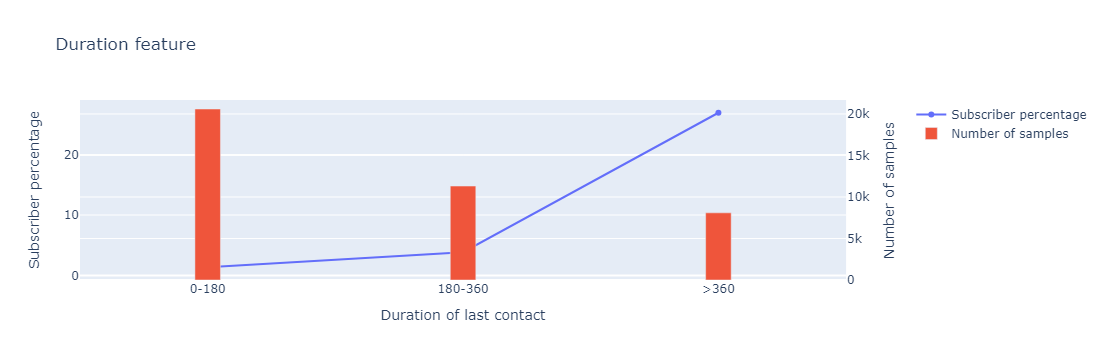

In [83]:
label = ['0-180','180-360','>360']
num_samp_duration = [(df[(0 <= df['duration']) & (df['duration'] <= 180)]).shape[0],(df[(180 < df['duration']) & (df['duration'] <= 360)]).shape[0],(df[(df['duration'] > 360)].shape[0])]
perc_duration = [round((df_sub[(0 <= df_sub['duration']) & (df_sub['duration'] <= 180)]).shape[0]/num_samp_duration[0]*100,2),round((df_sub[(180 < df_sub['duration']) & (df_sub['duration'] <= 360)]).shape[0]/num_samp_duration[1]*100,2),round((df_sub[(df_sub['duration'] > 360)]).shape[0]/num_samp_duration[2]*100,2)]

# Create Plot

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_duration, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_duration, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Duration feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Duration of last contact")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

In [84]:
def func(x):
    if x >= 0 and x<=180:
        return '0-3 minutes'
    elif x>180 and x<=360:
        return '3-6 minutes'
    else:
        return 'greater than 6 minutes'
df['duration'] = df['duration'].apply(func)

#### Campaign

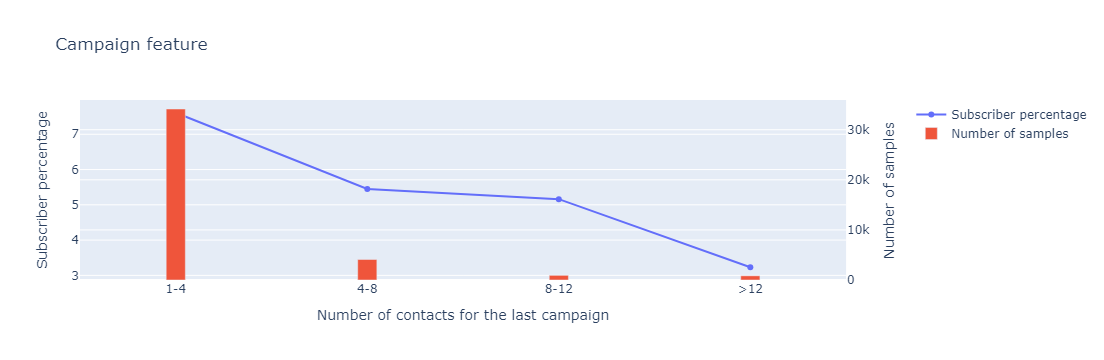

In [85]:
label = ['1-4','4-8','8-12','>12']
num_samp_cam = [(df[(1 <= df['campaign']) & (df['campaign'] <= 4)]).shape[0],(df[(4 < df['campaign']) & (df['campaign'] <= 8)]).shape[0],(df[(8 < df['campaign']) & (df['campaign'] <= 12)]).shape[0],(df[(df['campaign'] > 12)].shape[0])]
perc_cam = [round((df_sub[(1 <= df_sub['campaign']) & (df_sub['campaign'] <= 4)]).shape[0]/num_samp_cam[0]*100,2),round((df_sub[(4 < df_sub['campaign']) & (df_sub['campaign'] <= 8)]).shape[0]/num_samp_cam[1]*100,2),round((df_sub[(8 < df_sub['campaign']) & (df_sub['campaign'] <= 12)]).shape[0]/num_samp_cam[2]*100,2),round((df_sub[(df_sub['campaign'] > 12)]).shape[0]/num_samp_cam[3]*100,2)]

# Create Plot

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_cam, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_cam, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Campaign feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Number of contacts for the last campaign")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

Apparently the number of subscriber decreases with the number of contacts in the campaign. This feature can be dropped.

### New feature

In [86]:
def func(x):
    if (x >= 1 and x<=5) or (x>10 and x<=15) or x>=20:
        return 'yes'
    else:
        return 'no'

df['payDay'] = df['day'].apply(func)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  object
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  int64 
 5   balance    40000 non-null  object
 6   housing    40000 non-null  int64 
 7   loan       40000 non-null  int64 
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  object
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  int64 
 14  payDay     40000 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.6+ MB


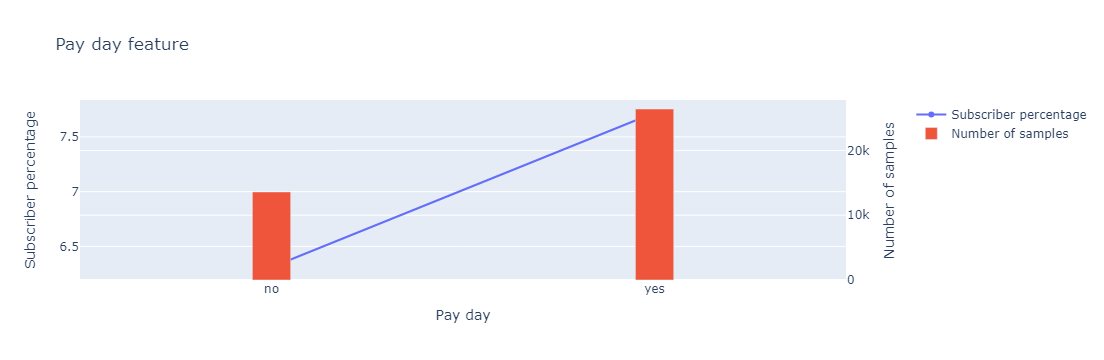

In [88]:
label = ['no','yes']
num_samp_payDay = []
perc_payDay = []
for l in label:
    num_samp_payDay.append((df[df.payDay==l]).shape[0])
for i,l in enumerate(label):
    perc_payDay.append(round((df[(df.payDay==l) & (df['y'] == 1)]).shape[0]/num_samp_payDay[i]*100,2))
# Create Plot


fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=label, y=perc_payDay, name="Subscriber percentage"),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=label, y=num_samp_payDay, name="Number of samples",width=0.1),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text= "Pay day feature"
)

# Set x-axis title
fig.update_xaxes(title_text="Pay day")

# Set y-axes titles
fig.update_yaxes(title_text="Subscriber percentage", secondary_y=False)
fig.update_yaxes(title_text="Number of samples", secondary_y=True)

fig

In [89]:
df['payDay']=pd.factorize(df['payDay'])[0]

### Dropping feature and converting categorical

In [90]:
df = df.drop(columns=['contact','day','month','campaign'])
df.head()

,age,job,marital,education,default,balance,housing,loan,duration,y,payDay
0,50-60,high profile job,married,tertiary,0,medium-balance,0,0,3-6 minutes,0,0
1,40-50,office job,single,secondary,0,low-balance,0,0,0-3 minutes,0,0
2,30-40,high profile job,married,secondary,0,low-balance,0,1,0-3 minutes,0,0
3,40-50,high profile job,married,unknown,0,low-balance,0,0,0-3 minutes,0,0
4,30-40,not full-time job,single,unknown,0,low-balance,1,0,3-6 minutes,0,0


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  object
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  int64 
 5   balance    40000 non-null  object
 6   housing    40000 non-null  int64 
 7   loan       40000 non-null  int64 
 8   duration   40000 non-null  object
 9   y          40000 non-null  int64 
 10  payDay     40000 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 3.4+ MB


In [92]:
#scaler = MinMaxScaler()
#df['age'] = scaler.fit_transform(df['age'].values.reshape(-1,1))
#df['balance'] = scaler.fit_transform(df['balance'].values.reshape(-1,1))
#df['duration'] = scaler.fit_transform(df['duration'].values.reshape(-1,1))

In [93]:
df.describe()

,default,housing,loan,y,payDay
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.020225,0.399225,0.173250,0.072400,0.339950
std,0.140771,0.489745,0.378468,0.259152,0.473698
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [94]:
df_term = pd.get_dummies(df, columns = ['age','marital','education','duration','job','balance'])
df_term.head()

,default,housing,loan,y,payDay,age_18-30,age_30-40,age_40-50,age_50-60,age_over60,...,education_unknown,duration_0-3 minutes,duration_3-6 minutes,duration_greater than 6 minutes,job_high profile job,job_not full-time job,job_office job,balance_high-balance,balance_low-balance,balance_medium-balance
0,0,0,0,0,0,False,False,False,True,False,...,False,False,True,False,True,False,False,False,False,True
1,0,0,0,0,0,False,False,True,False,False,...,False,True,False,False,False,False,True,False,True,False
2,0,0,1,0,0,False,True,False,False,False,...,False,True,False,False,True,False,False,False,True,False
3,0,0,0,0,0,False,False,True,False,False,...,True,True,False,False,True,False,False,False,True,False
4,0,1,0,0,0,False,True,False,False,False,...,True,False,True,False,False,True,False,False,True,False


### Prepare data

In [95]:
y = df_term['y']
X = df_term.drop(columns = ['y'])
print(X.shape, y.shape)

(40000, 25) (40000,)


In [96]:
X.head()

,default,housing,loan,payDay,age_18-30,age_30-40,age_40-50,age_50-60,age_over60,marital_divorced,...,education_unknown,duration_0-3 minutes,duration_3-6 minutes,duration_greater than 6 minutes,job_high profile job,job_not full-time job,job_office job,balance_high-balance,balance_low-balance,balance_medium-balance
0,0,0,0,0,False,False,False,True,False,False,...,False,False,True,False,True,False,False,False,False,True
1,0,0,0,0,False,False,True,False,False,False,...,False,True,False,False,False,False,True,False,True,False
2,0,0,1,0,False,True,False,False,False,False,...,False,True,False,False,True,False,False,False,True,False
3,0,0,0,0,False,False,True,False,False,False,...,True,True,False,False,True,False,False,False,True,False
4,0,1,0,0,False,True,False,False,False,False,...,True,False,True,False,False,True,False,False,True,False


### Training and evaluate XGBoost

Data are divided in two sets: data for Cross Validation, which we will call train_test and data for testing the final models, which we will call gtest for global test.

In [97]:
X_train_test, X_gtest, y_train_test, y_gtest = train_test_split(X, y, test_size=0.20, random_state=0)

In [98]:
counter = Counter(y_train_test)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print(counter[0])
print(counter[1])
print('Estimate: %.3f' % estimate)

29679
2321
Estimate: 12.787


In [99]:
# Instnatiating the models 
svm = SVC()
tree = DecisionTreeClassifier()
rf =  RandomForestClassifier(max_depth=2, random_state=0)


bst = XGBClassifier(n_estimators=10000, max_depth=5, learning_rate=1, objective='binary:logistic',scale_pos_weight=estimate)

# Cross-validation
cv_results_svm = cross_validate(svm, X_train_test, y_train_test, cv=5, return_estimator=True)
cv_results_tree = cross_validate(tree, X_train_test, y_train_test, cv=5, return_estimator=True)
cv_results_rf = cross_validate(rf, X_train_test, y_train_test, cv=5, return_estimator=True)
cv_results_bst = cross_validate(bst, X_train_test, y_train_test, cv=5, return_estimator=True)

In [100]:
model_preds = {
    #"Logistic Regression": scores_lr.mean(),
    "Support Vector Machine": cv_results_svm['test_score'].mean(),
    "Decision Tree": cv_results_tree['test_score'].mean(),
    "Random forest": cv_results_rf['test_score'].mean(),
    "XGBoost":  cv_results_bst['test_score'].mean()
}

for model, scores in model_preds.items():
    print(f"{model} Mean accuracy:\n{scores}", sep="\n\n")

Support Vector Machine Mean accuracy:
0.9279375
Decision Tree Mean accuracy:
0.9184374999999999
Random forest Mean accuracy:
0.9274687500000001
XGBoost Mean accuracy:
0.8005937500000002


In [101]:
def global_test_score(cv_results):
    gtest_score = []
    for i in range(len(cv_results['estimator'])):
      gtest_score.append(cv_results['estimator'][i].score(X_gtest, y_gtest))
    return gtest_score

In [102]:
model_preds = {
    #"Logistic Regression": scores_lr.mean(),
    "Support Vector Machine": global_test_score(cv_results_svm),
    "Decision Tree": global_test_score(cv_results_tree),
    "Random forest": global_test_score(cv_results_rf),
    "XGBoost":  global_test_score(cv_results_bst)
}

for model, scores in model_preds.items():
    print(f"{model} Mean accuracy:\n{sum(scores) / len(scores)}", sep="\n\n")

Support Vector Machine Mean accuracy:
0.9281500000000001
Decision Tree Mean accuracy:
0.92065
Random forest Mean accuracy:
0.928125
XGBoost Mean accuracy:
0.801975


It may seems that the worst model is XGBoost, but the high accuracy of the other models it's just due to the unbalanced data. Pratically because the number of positive samples is low, also without classifying any of them the accuracy will be high, while recall and precision very low. This is not the case with XGBoost because we balance the data with the weight matrix. So let's proceed with XGBoost.

In [103]:
print(cv_results_bst['test_score'])

[0.79171875 0.80546875 0.7971875  0.8034375  0.80515625]


In [104]:
scores =  global_test_score(cv_results_bst)
print(scores)

[0.80375, 0.805, 0.801375, 0.79825, 0.8015]


In [105]:
bst = cv_results_bst['estimator'][1]
bst_preds = bst.predict(X_gtest)

In [106]:
y_gtest.shape

(8000,)

In [107]:
subscriber = []
for x in y_gtest:
    if x ==1:
        subscriber.append(x)
print(len(subscriber))

575


In [108]:
confusion_matrix(y_gtest.values, bst_preds)

array([[6055, 1370],
       [ 190,  385]], dtype=int64)

On a sample of 575 positive the model correctly identify 385 samples misclassifying 190 samples. While on a sample of 7425 negative samples the model misclassify 1370 samples correctly identifying 6055 samples.

In [109]:
print(cv_results_bst['test_score'])

[0.79171875 0.80546875 0.7971875  0.8034375  0.80515625]


In [110]:
print(f"Results:\n{classification_report(y_gtest, bst_preds)}", sep="\n\n")

Results:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      7425
           1       0.22      0.67      0.33       575

    accuracy                           0.81      8000
   macro avg       0.59      0.74      0.61      8000
weighted avg       0.92      0.81      0.85      8000



The model reach an accuracy of 81% with high prexision and recall for the negative class. For the positive class we have a very low precision and a recall of 67%. The results for the posive class can be improved collecting more samples.

### Features importance

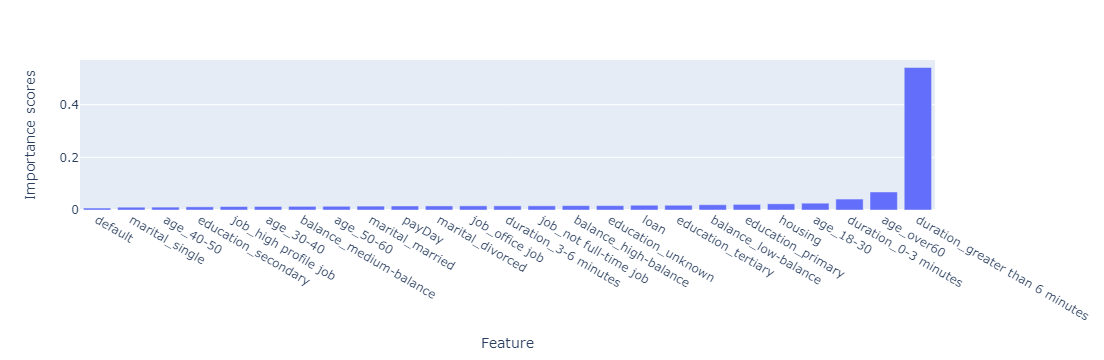

In [111]:
# bult-in feature importance
sorted_idx = bst.feature_importances_.argsort()
fig = px.bar(x=X_train_test.columns[sorted_idx], y=bst.feature_importances_[sorted_idx], labels={'x':'Feature', 'y':'Importance scores'})
fig

### Conclusion

The unbalanced dataset make impossible create an accurate model to correctly identify positive samples. More samples of subscriber should be collected or synthetized. In order to partially balancing the dataset I used the weight matrix of the classifier. From the feature importance analysis on the best model the duration of the call grater than 6 minutes and the age over 60 seems to be key feature in order to predict subscriber. This confirm the result of the data analysis where the retired people and over 60 are more incline to buy and people with negative balance and active loans are less incline to buy. Additionally From the data analysis the number of subscriber seems also to increase with the education grade and the students are more incline to subscribe. 